# Load Package

In [4]:
# Important libraries
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import sklearn
from sklearn.metrics import auc
from matplotlib.gridspec import SubplotSpec
import joblib
# import gpflow

# KNN
from scipy.spatial import KDTree
# Cond Gaussian
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.stats import pearsonr
# Weighted
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# import weightedcalcs as wc
# Gaussian Copula
from scipy import stats
from scipy.stats import norm, truncnorm

# BNN
# import torchbnn as bnn
import torch.nn as nn
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.model_selection import ParameterGrid
import random

# DER
# from lightning.pytorch import Trainer, seed_everything
# from lightning import LightningDataModule
# from torch_uncertainty.models.mlp import mlp
# from torch_uncertainty.losses import DERLoss
# from torch_uncertainty.routines import RegressionRoutine
# from torch_uncertainty.layers.distributions import NormalInverseGammaLayer
# from lightning.pytorch.callbacks import EarlyStopping
import contextlib

data_label = "mimic"
seed = 2023

# File paths
fp_notebooks_folder = "./"
fp_code_folder = "../../"
fp_processed_folder = os.path.join(fp_code_folder, "../processed_data")
fp_downsampled_folder = os.path.join(fp_processed_folder, "downsampled")
fp_downsampled_dropna_file = os.path.join(fp_downsampled_folder, "dropna.csv")
fp_downsampled_scaler_file = os.path.join(fp_downsampled_folder, "scaler.pkl")

fp_project_checkpoints = os.path.join(fp_code_folder, "checkpoints", data_label)
fp_tuning = os.path.join(fp_project_checkpoints, "tuning")
fp_project_models = os.path.join(fp_project_checkpoints, "models")
fp_project_predictions = os.path.join(fp_project_checkpoints, "predictions")
fp_project_pi_predictions = os.path.join(fp_project_checkpoints, "pi_predictions")
fp_project_model_evaluations = os.path.join(fp_project_checkpoints, "model_evaluation")
fp_project_consolidated_results = os.path.join(fp_project_checkpoints, "consolidated_results")
fp_time_log = os.path.join(fp_project_consolidated_results, "runtime.log")

def create_folder(fp):
    if not os.path.exists(fp):
        os.makedirs(fp)
        return True
    else:
        False

def create_all_seed_folders(cur_seed):
    fp_checkpoint_folders = [fp_project_models, fp_tuning, fp_project_predictions, fp_project_model_evaluations, fp_project_pi_predictions]
    for fp_folder in fp_checkpoint_folders:
        fp = os.path.join(fp_folder, str(cur_seed))
        create_folder(fp)
    print(f"All folders created for seed = {cur_seed}!")

batch_size = 64

# Create all folders
create_all_seed_folders(seed)
create_folder(fp_project_consolidated_results)

# Check GPU is available
# print(tf.config.list_physical_devices('GPU'))

# function to show df
def display_df(df):
    display(df.head())
    print("Shape:", df.shape)

All folders created for seed = 2023!


# Load Data

In [5]:
df = pd.read_csv(fp_downsampled_dropna_file, index_col=0)
df

,ABPdias (mmHg)_mean Min0,RESP (bpm)_mean Min0,ABPmean (mmHg)_mean Min0,ABPsys (mmHg)_mean Min0,SpO2 (%)_mean Min0,HR (bpm)_mean Min0,ABPdias (mmHg)_std Min0,RESP (bpm)_std Min0,ABPmean (mmHg)_std Min0,ABPsys (mmHg)_std Min0,...,ABPsys (mmHg)_mean PredMin3,SpO2 (%)_mean PredMin3,HR (bpm)_mean PredMin3,target_index,input_start_index,input_end_index,record,train,valid,test
18,0.656458,0.756224,0.787620,0.701673,-0.095824,0.014185,0.068855,0.975804,0.095789,0.134008,...,0.893539,-0.230382,-0.227792,"[23, 24, 25]",18,22,048n,True,False,False
19,0.421417,-0.150253,0.395037,0.216258,0.052653,-0.091619,0.553956,0.333454,0.520543,0.416795,...,0.730120,-0.235022,-0.282653,"[24, 25, 26]",19,23,048n,True,False,False
20,0.120835,-0.223392,0.114355,0.063734,-0.132944,-0.198402,0.375286,0.401908,0.308951,0.266733,...,0.822119,-0.230382,-0.231711,"[25, 26, 27]",20,24,048n,True,False,False
21,0.607867,0.339555,0.601120,0.493465,-0.689736,-0.163586,0.178803,0.303800,0.154450,0.129817,...,0.526754,-0.081905,-0.225833,"[26, 27, 28]",21,25,048n,True,False,False
22,0.714088,-0.615682,0.649610,0.555201,-0.527338,-0.294409,0.261310,0.436255,0.203398,0.214778,...,0.089155,-0.583017,-0.265019,"[27, 28, 29]",22,26,048n,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119680,-0.962839,0.392747,-0.782710,-0.096053,0.094413,0.167012,0.082489,0.206834,0.094674,0.122280,...,0.179338,0.043373,0.229710,"[934, 935, 936]",929,933,476n,True,False,False
119681,-0.830629,0.352853,-0.569167,0.159970,0.238251,0.213056,0.086568,0.145809,0.131554,0.155300,...,0.086129,0.270730,0.230690,"[935, 936, 937]",930,934,476n,True,False,False
119682,-0.808029,0.454804,-0.553315,0.105497,0.182571,0.245385,0.040305,0.211136,0.039045,0.052431,...,0.242284,0.270730,0.292409,"[936, 937, 938]",931,935,476n,True,False,False
119683,-0.810289,0.363934,-0.529070,0.107312,0.150092,0.198361,0.075201,0.079052,0.078452,0.081852,...,0.499518,0.321769,0.289470,"[937, 938, 939]",932,936,476n,True,False,False


In [6]:
df["train"].sum()

38769

In [7]:
df["valid"].sum()

8765

In [8]:
df["test"].sum()

12032

In [9]:
predictors = df.columns[:60].to_list()
print(predictors)

['ABPdias (mmHg)_mean Min0', 'RESP (bpm)_mean Min0', 'ABPmean (mmHg)_mean Min0', 'ABPsys (mmHg)_mean Min0', 'SpO2 (%)_mean Min0', 'HR (bpm)_mean Min0', 'ABPdias (mmHg)_std Min0', 'RESP (bpm)_std Min0', 'ABPmean (mmHg)_std Min0', 'ABPsys (mmHg)_std Min0', 'SpO2 (%)_std Min0', 'HR (bpm)_std Min0', 'ABPdias (mmHg)_mean Min1', 'RESP (bpm)_mean Min1', 'ABPmean (mmHg)_mean Min1', 'ABPsys (mmHg)_mean Min1', 'SpO2 (%)_mean Min1', 'HR (bpm)_mean Min1', 'ABPdias (mmHg)_std Min1', 'RESP (bpm)_std Min1', 'ABPmean (mmHg)_std Min1', 'ABPsys (mmHg)_std Min1', 'SpO2 (%)_std Min1', 'HR (bpm)_std Min1', 'ABPdias (mmHg)_mean Min2', 'RESP (bpm)_mean Min2', 'ABPmean (mmHg)_mean Min2', 'ABPsys (mmHg)_mean Min2', 'SpO2 (%)_mean Min2', 'HR (bpm)_mean Min2', 'ABPdias (mmHg)_std Min2', 'RESP (bpm)_std Min2', 'ABPmean (mmHg)_std Min2', 'ABPsys (mmHg)_std Min2', 'SpO2 (%)_std Min2', 'HR (bpm)_std Min2', 'ABPdias (mmHg)_mean Min3', 'RESP (bpm)_mean Min3', 'ABPmean (mmHg)_mean Min3', 'ABPsys (mmHg)_mean Min3', 'SpO

In [10]:
pred_cols_1 = [col for col in df.columns if "PredMin1" in col]
pred_cols_2 = [col for col in df.columns if "PredMin2" in col]
pred_cols_3 = [col for col in df.columns if "PredMin3" in col]
print(pred_cols_1)
print(pred_cols_2)
print(pred_cols_3)

['ABPdias (mmHg)_mean PredMin1', 'RESP (bpm)_mean PredMin1', 'ABPmean (mmHg)_mean PredMin1', 'ABPsys (mmHg)_mean PredMin1', 'SpO2 (%)_mean PredMin1', 'HR (bpm)_mean PredMin1']
['ABPdias (mmHg)_mean PredMin2', 'RESP (bpm)_mean PredMin2', 'ABPmean (mmHg)_mean PredMin2', 'ABPsys (mmHg)_mean PredMin2', 'SpO2 (%)_mean PredMin2', 'HR (bpm)_mean PredMin2']
['ABPdias (mmHg)_mean PredMin3', 'RESP (bpm)_mean PredMin3', 'ABPmean (mmHg)_mean PredMin3', 'ABPsys (mmHg)_mean PredMin3', 'SpO2 (%)_mean PredMin3', 'HR (bpm)_mean PredMin3']


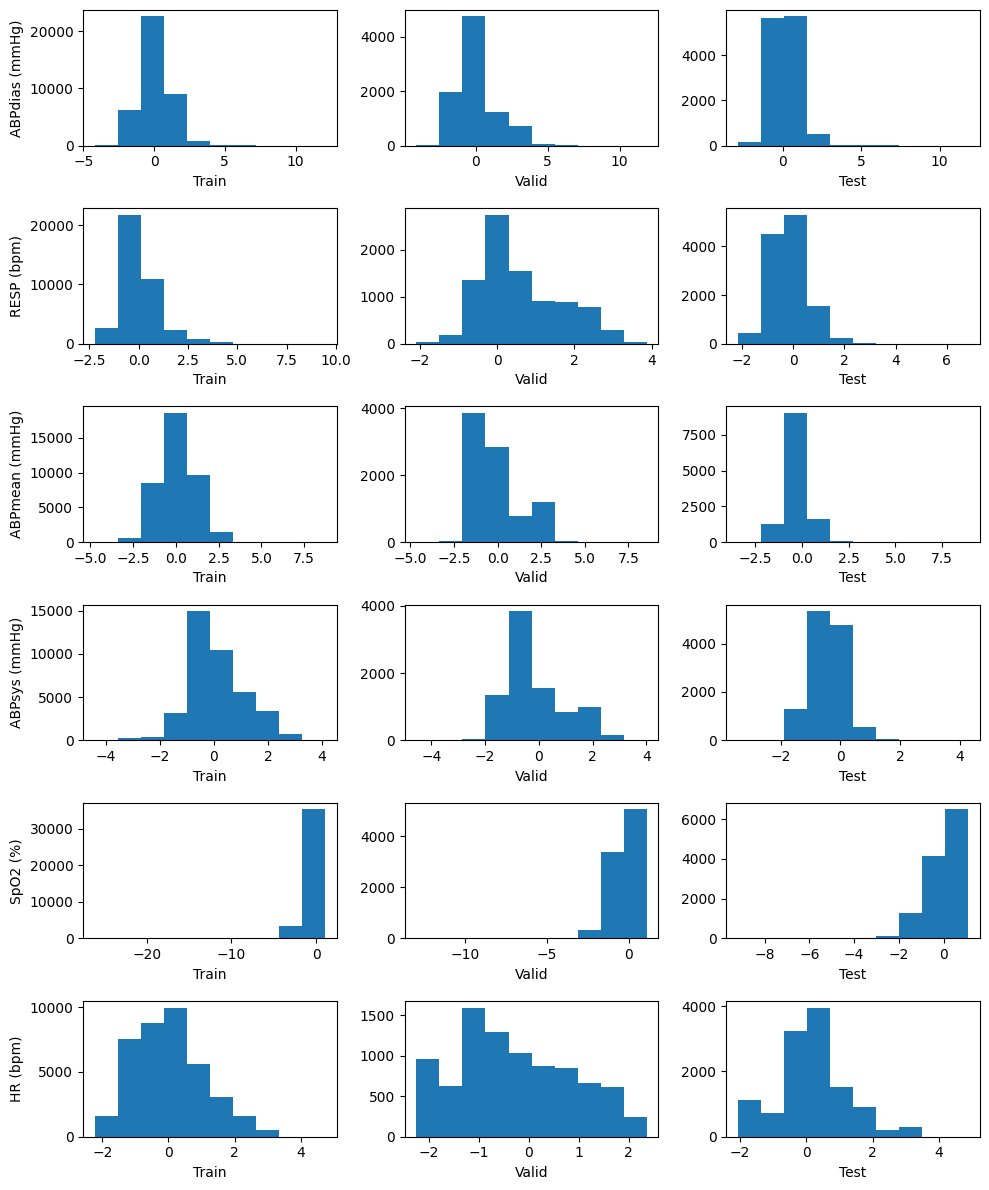

In [11]:
# Make train, validation and test sets
def train_valid_test_split(df, pred_cols):
    df_train, df_valid, df_test = df[df["train"]], df[df["valid"]], df[df["test"]]
    num_pred_cols = len(pred_cols)
    
    # Plot distribution of pred_col for each set
    fig, axes = plt.subplots(num_pred_cols, 3, figsize=(10, 2*num_pred_cols))
    for i, col in enumerate(pred_cols):
        axes[i, 0].hist(df_train[col])
        axes[i, 0].set_xlabel("Train")
        axes[i, 0].set_ylabel(col.split("_")[0])
        axes[i, 1].hist(df_valid[col])
        axes[i, 1].set_xlabel("Valid")
        axes[i, 2].hist(df_test[col])
        axes[i, 2].set_xlabel("Test")
    
    plt.tight_layout()

    return df_train, df_valid, df_test

df_train_1, df_valid_1, df_test_1 = train_valid_test_split(df, pred_cols=pred_cols_1)

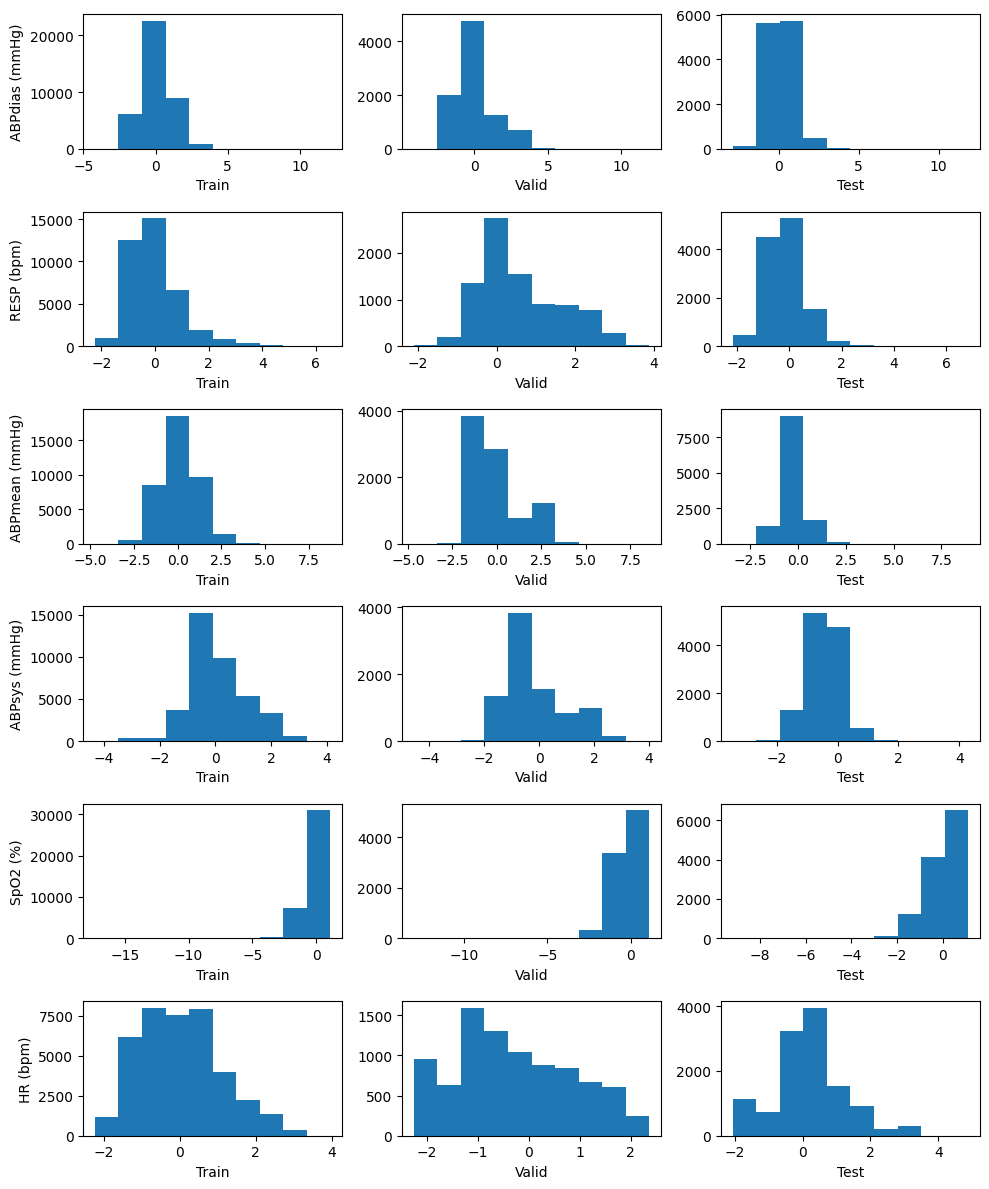

In [12]:
df_train_2, df_valid_2, df_test_2 = train_valid_test_split(df, pred_cols=pred_cols_2)

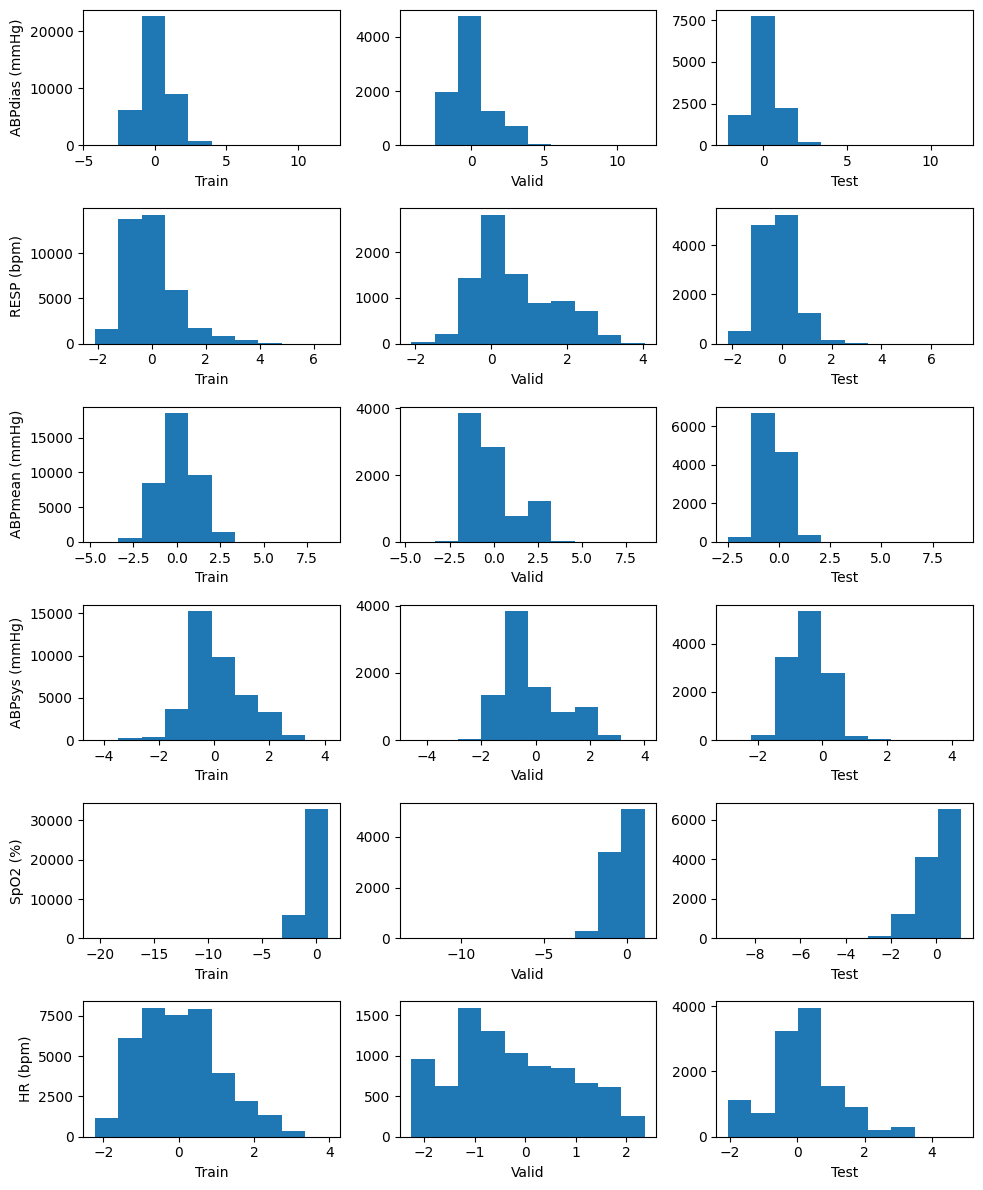

In [13]:
df_train_3, df_valid_3, df_test_3 = train_valid_test_split(df, pred_cols=pred_cols_3)

# Export

In [14]:
split_dict = {
    "t+1": {"train_df": df_train_1, "valid_df": df_valid_1, "test_df": df_test_1, "outputs": pred_cols_1},
    "t+2": {"train_df": df_train_2, "valid_df": df_valid_2, "test_df": df_test_2, "outputs": pred_cols_2},
    "t+3": {"train_df": df_train_3, "valid_df": df_valid_3, "test_df": df_test_3, "outputs": pred_cols_3},
}
joblib.dump(split_dict, os.path.join(fp_processed_folder, "mimic_split_dict.joblib"))

['../../../processed_data/mimic_split_dict.joblib']